# 0.1 Pytorch Workflow Fundamentals

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
# Set device type
device = "cuda" if torch.cuda.is_available() else "cpu"
device
torch.__version__


'2.0.1+cu117'

# Data (preparing and loading)

In [2]:
# Generate data 
# Know parameters
weight = 0.7
bias = 0.3
# Create data
start = 0
end = 1
step = .02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

In [3]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

# Split data into a train and test sets

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

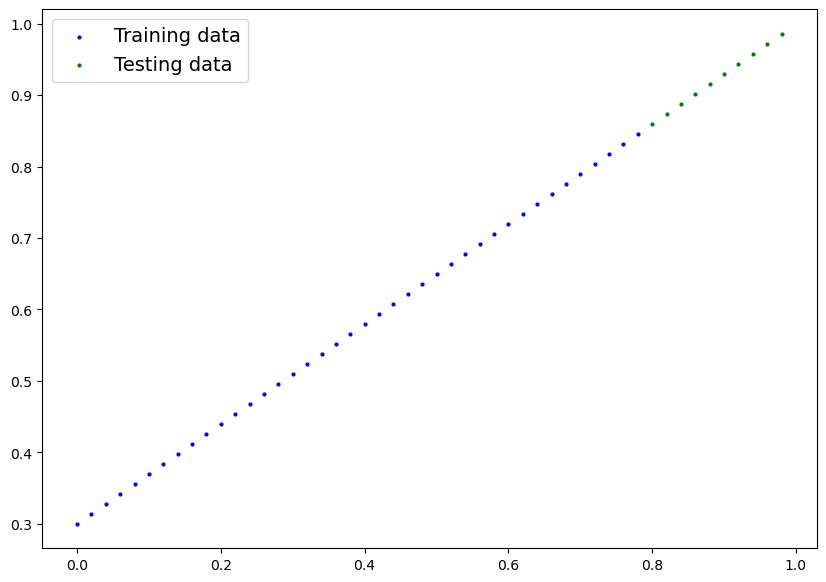

In [6]:
plot_predictions()

# Build a model

In [7]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype = torch.float), requires_grad = True)
        self.bias = nn.Parameter(torch.randn(1, dtype = torch.float),requires_grad = True)
    
    # Forward defines the computation in the model
    # Gradient descent function
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

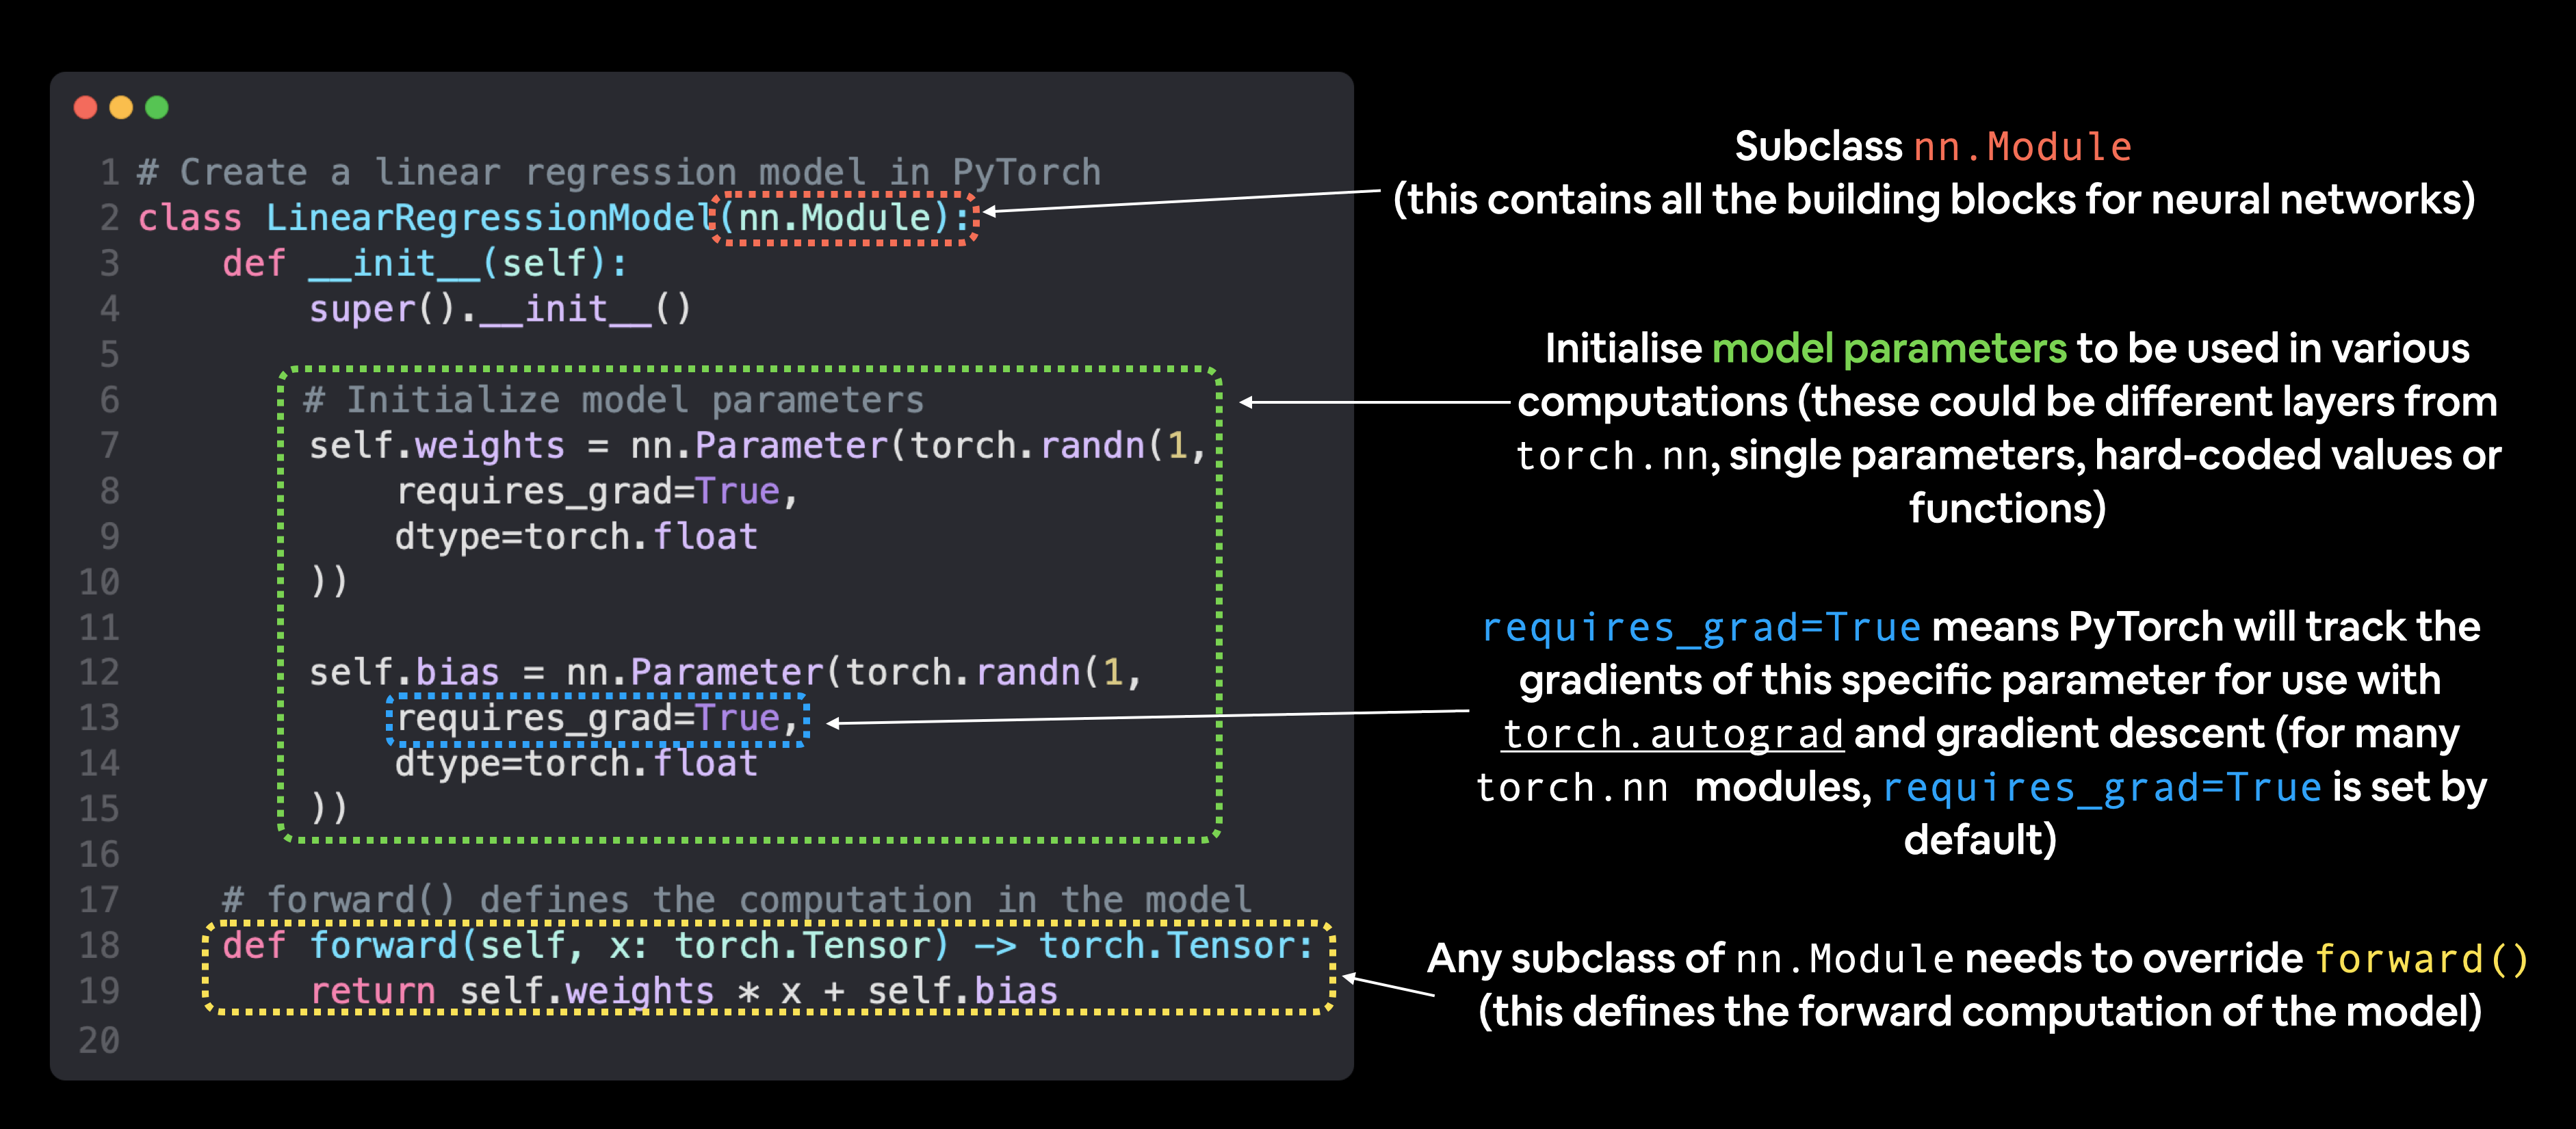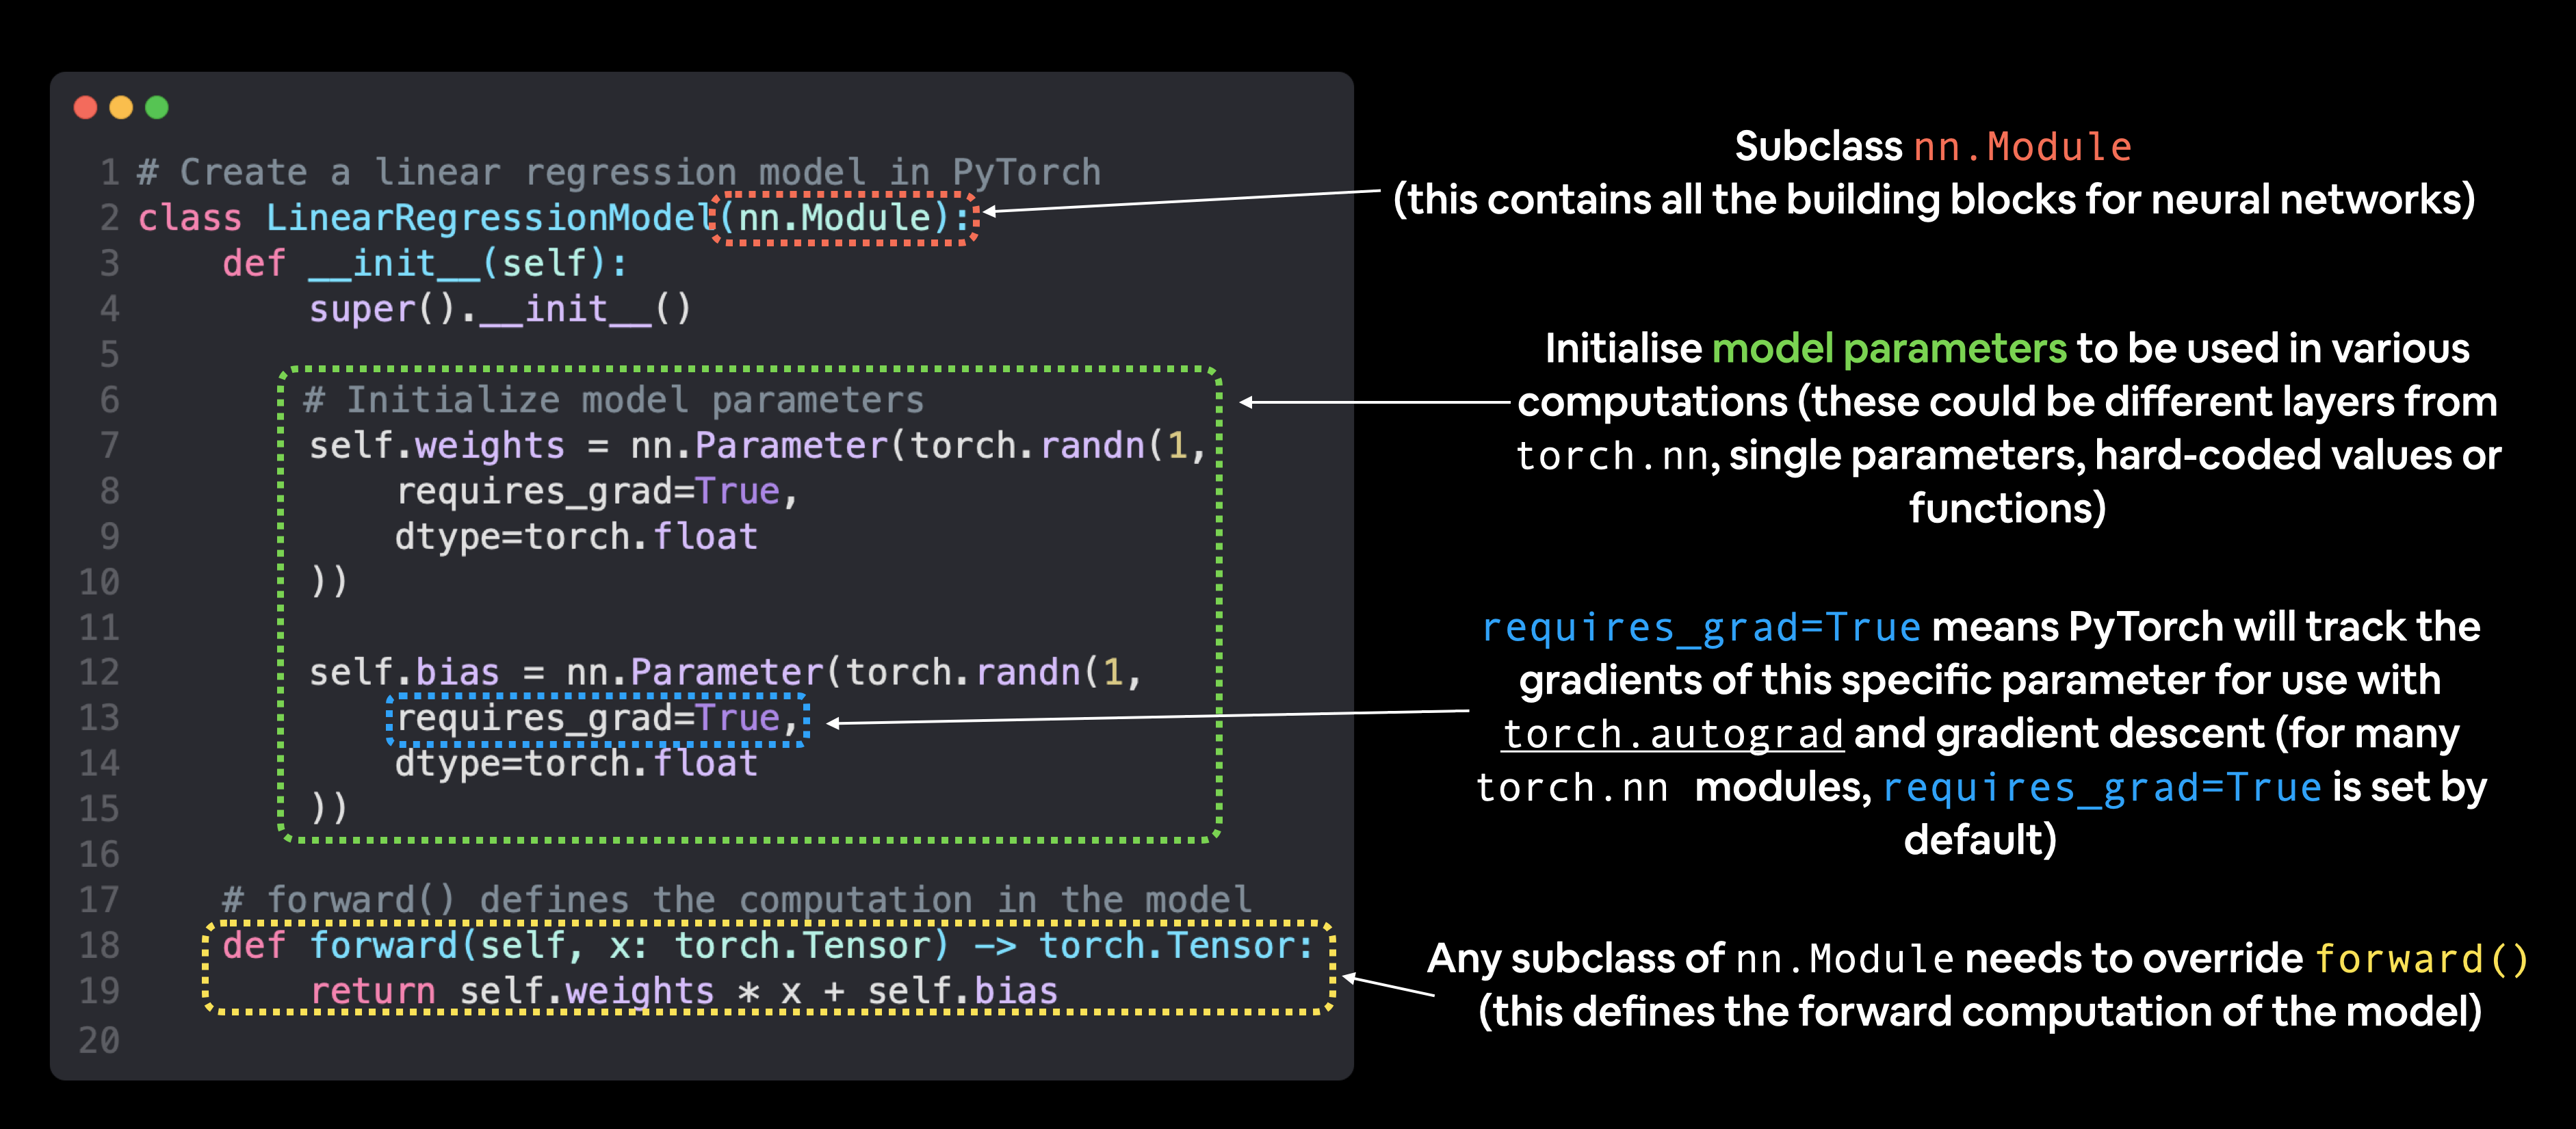

## Check the contents of a PyTorch model

In [8]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel().to(device)

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1288], device='cuda:0', requires_grad=True)]

In [9]:
# List of named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], device='cuda:0')),
             ('bias', tensor([0.1288], device='cuda:0'))])

# Making predictions using torch.inference_mode()

In [10]:

# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test.to(device))

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [11]:

# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], device='cuda:0')


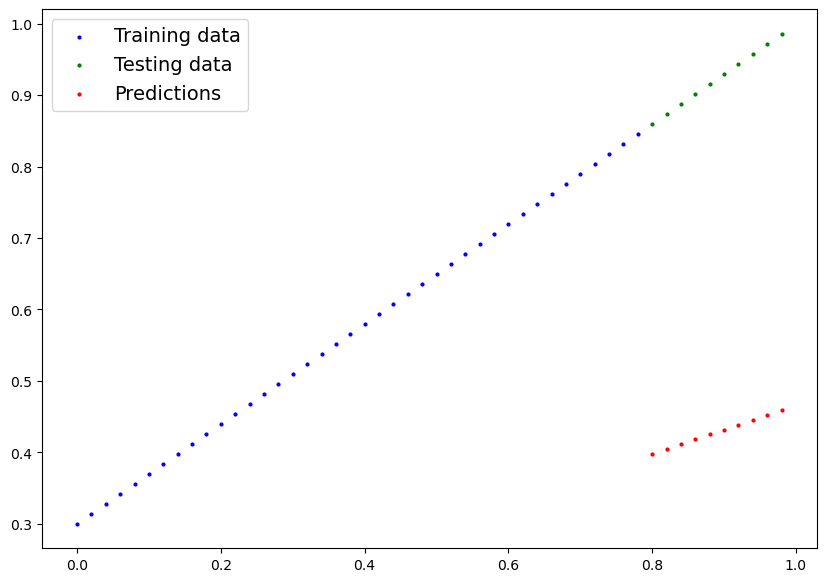

In [12]:

plot_predictions(predictions=y_preds.cpu().numpy())

# Creating a loss function and optimizer in PyTorch

In [13]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

# Creating an optimization loop in PyTorch

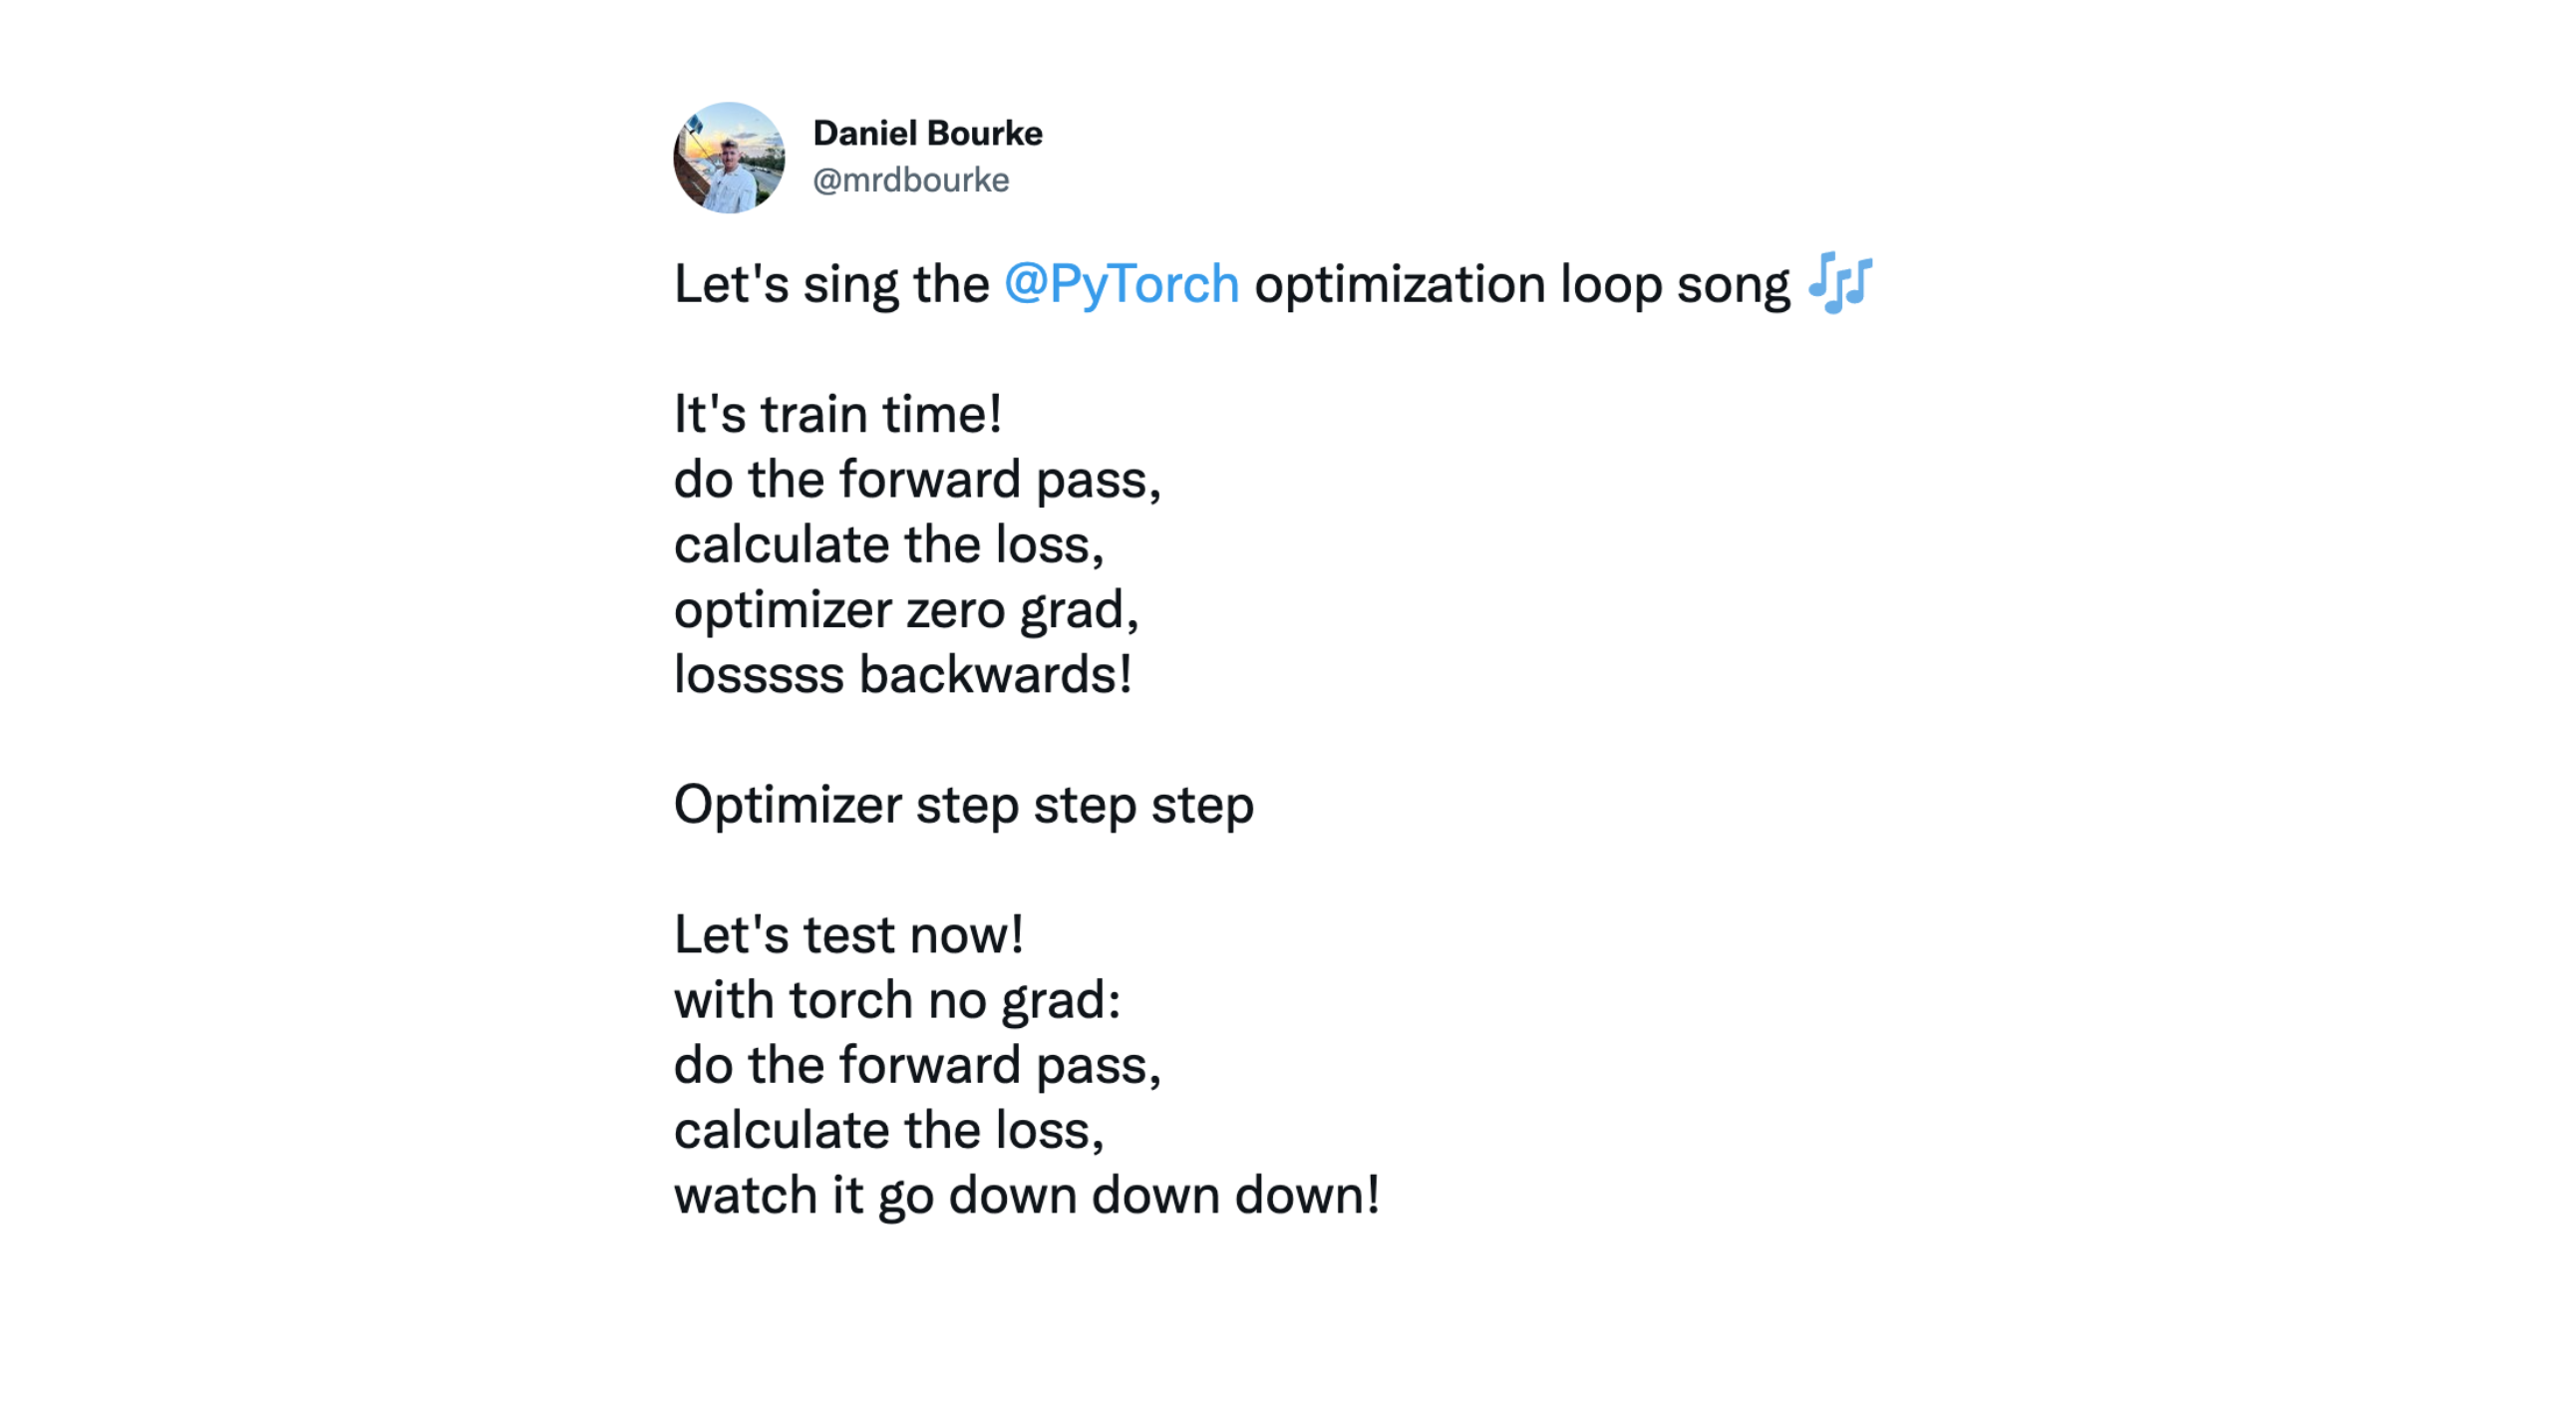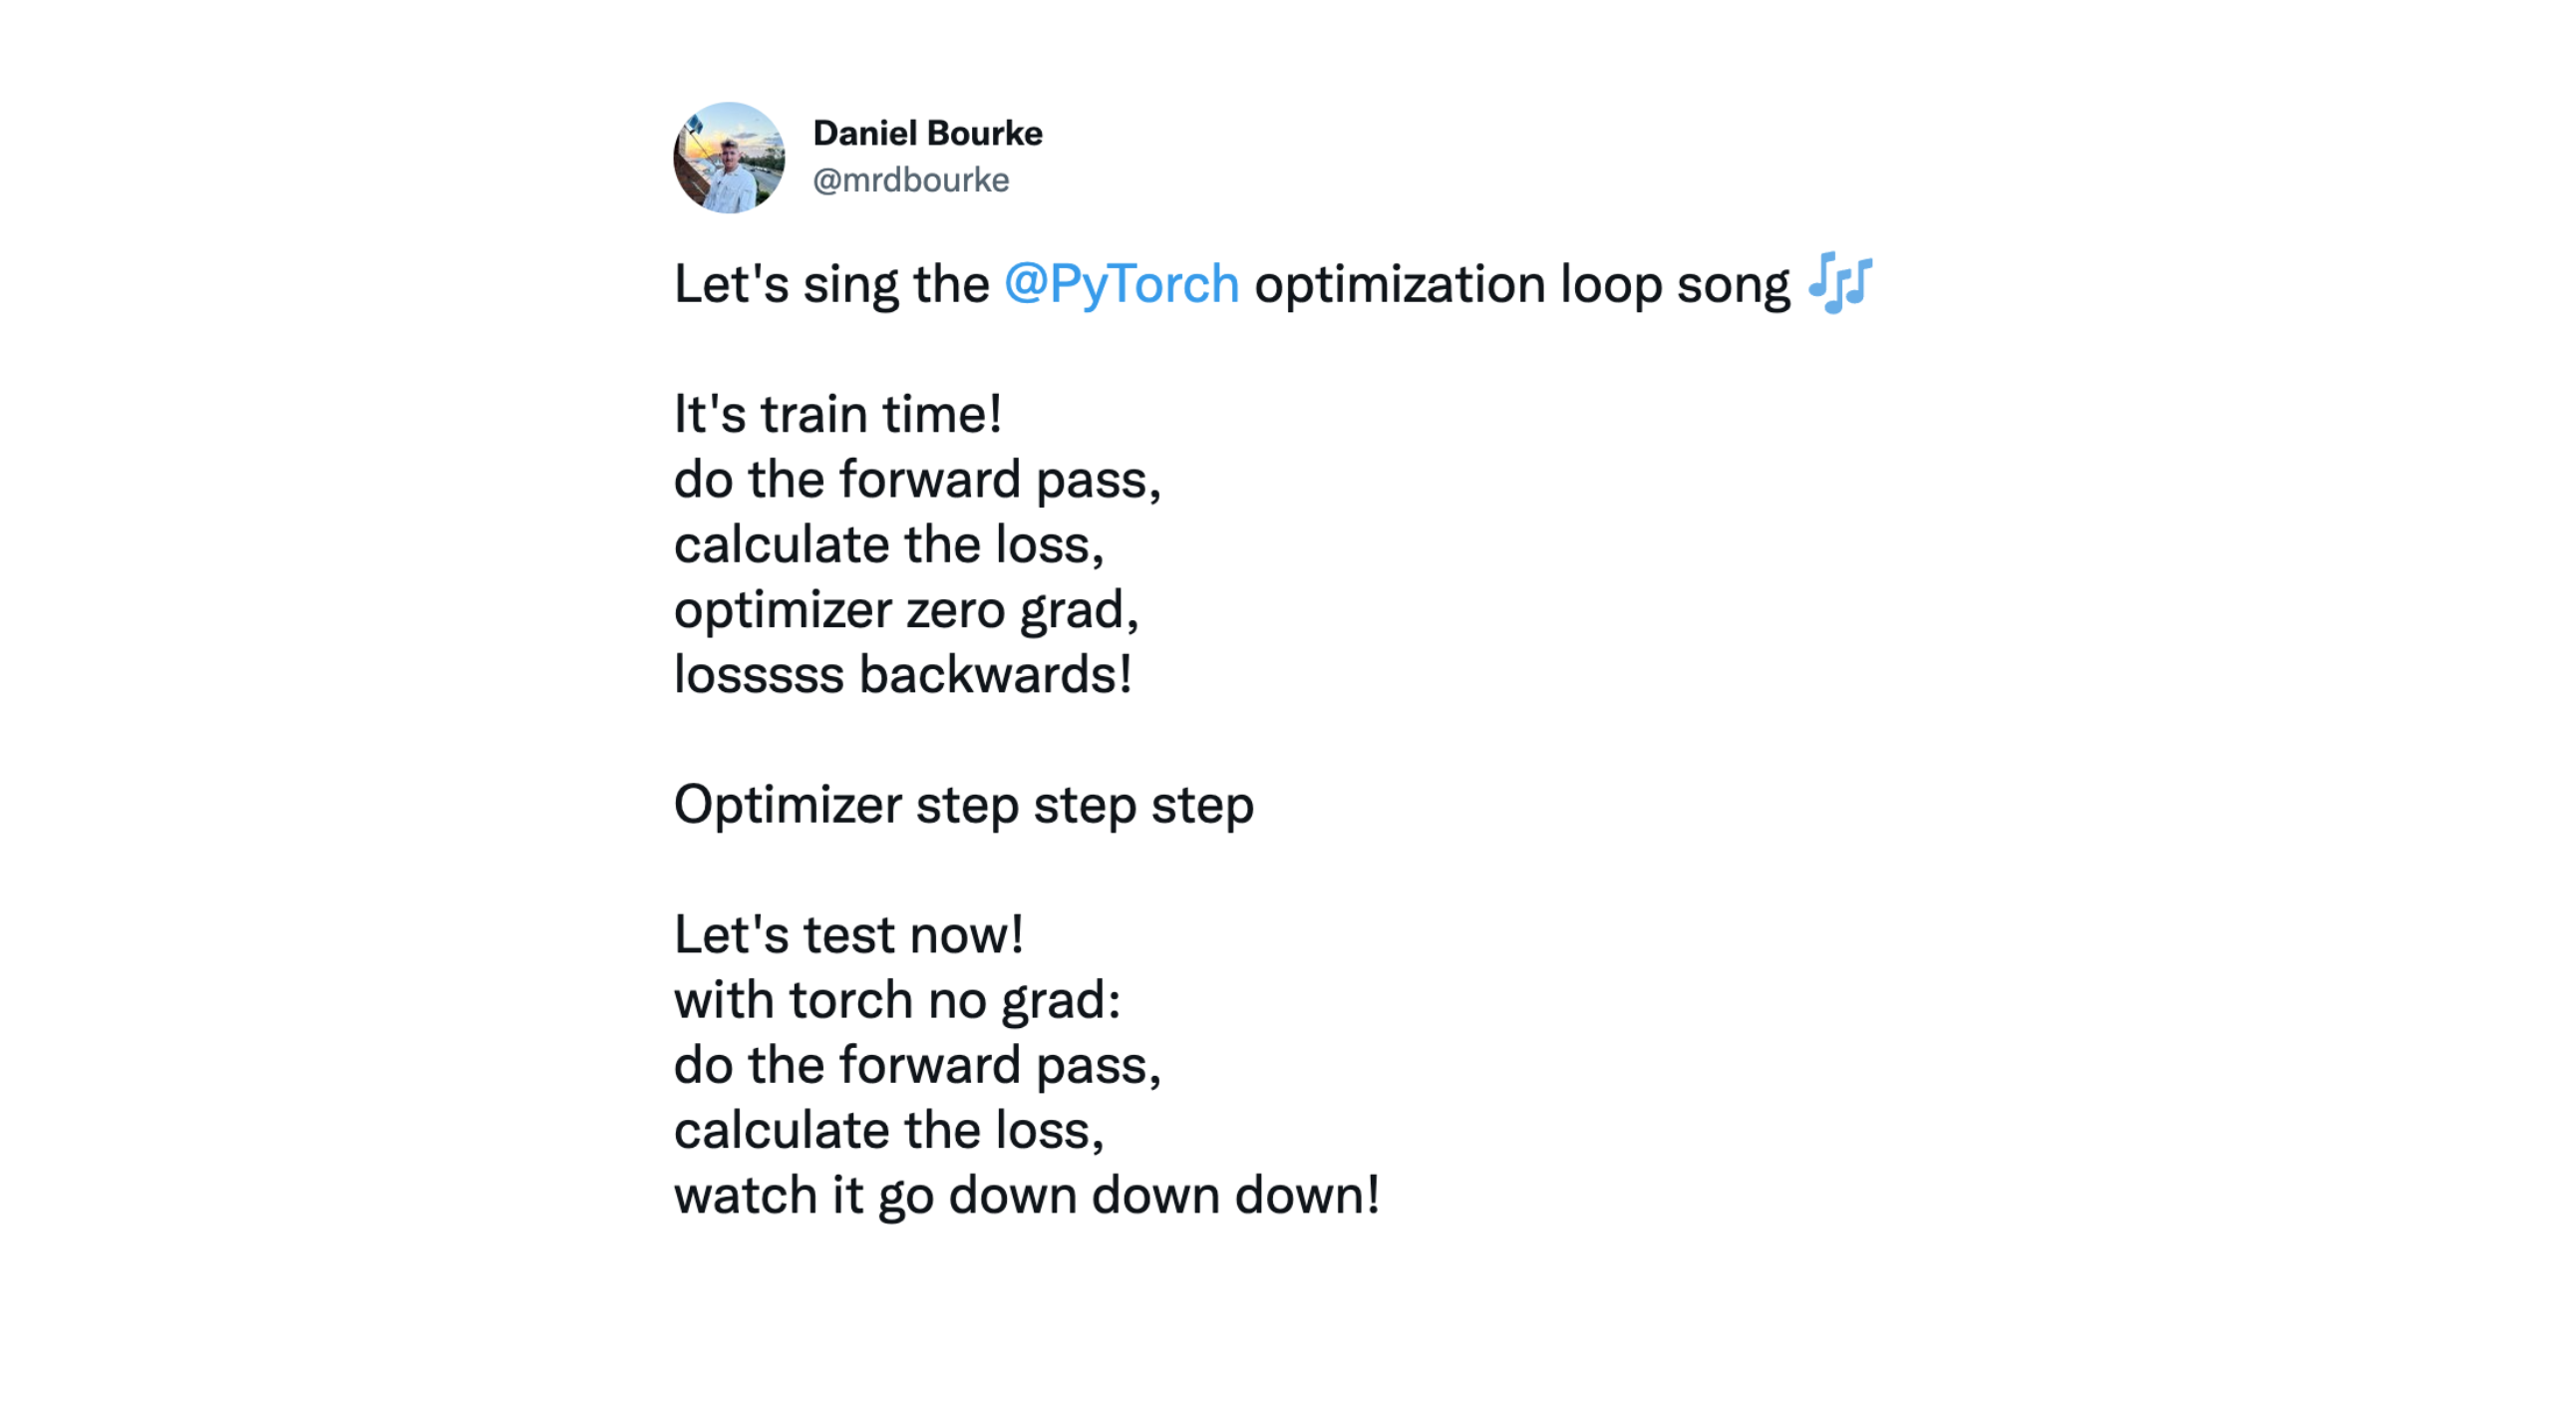

In [14]:
from tqdm import tqdm
torch.manual_seed(42)

epochs = 400

train_loss_val = []
test_loss_val = []
epoch_count = []

for epoch in tqdm(range(epochs)) :
    # Trainnng
    model_0.train()
    # 1 Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train.to(device))
    loss = loss_fn(y_pred, y_train.to(device)).to(device)
    optimizer.zero_grad()
    # Loss backwards
    loss.backward()
    # Progress the optimizer
    optimizer.step()
    
    ## Testing
    model_0.eval() # Model evaluation mode
    
    with torch.inference_mode():
        # 1. Forward pass on test dasta
        test_pred = model_0(X_test.to(device))
        test_loss = loss_fn(test_pred, y_test.type(torch.float).to(device)).to(device)
        
        # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_val.append(loss.detach().cpu().numpy())
            test_loss_val.append(test_loss.detach().cpu().numpy())
            # print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


100%|███████████████████████████████████████| 400/400 [00:00<00:00, 1679.56it/s]


In [15]:
!nvidia-smi

/bin/bash: /home/nhat/miniconda3/envs/test/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Wed Jun  7 20:45:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P2    23W /  70W |    752MiB /  6144MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------

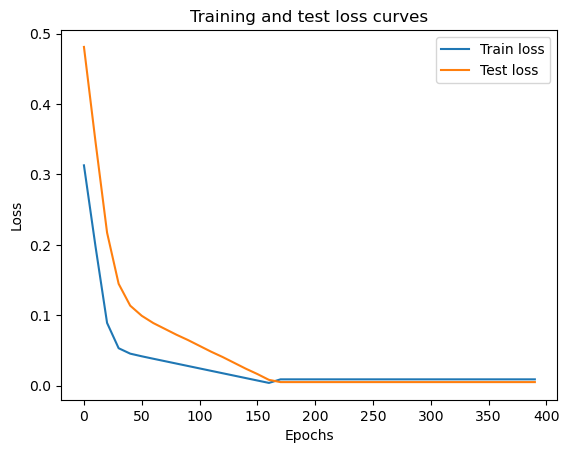

In [16]:

# Plot the loss curves
plt.plot(epoch_count, train_loss_val, label="Train loss")
plt.plot(epoch_count, test_loss_val, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [17]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990], device='cuda:0')), ('bias', tensor([0.3093], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# 4. Making predictions with a trained PyTorch model (inference)

In [19]:

# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test.to(device))
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]], device='cuda:0')

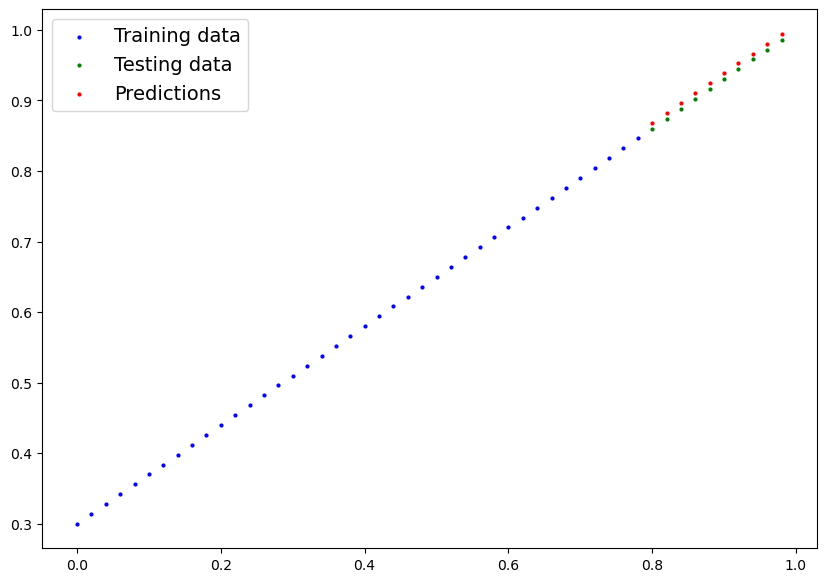

In [20]:
plot_predictions(predictions=y_preds.cpu().numpy())

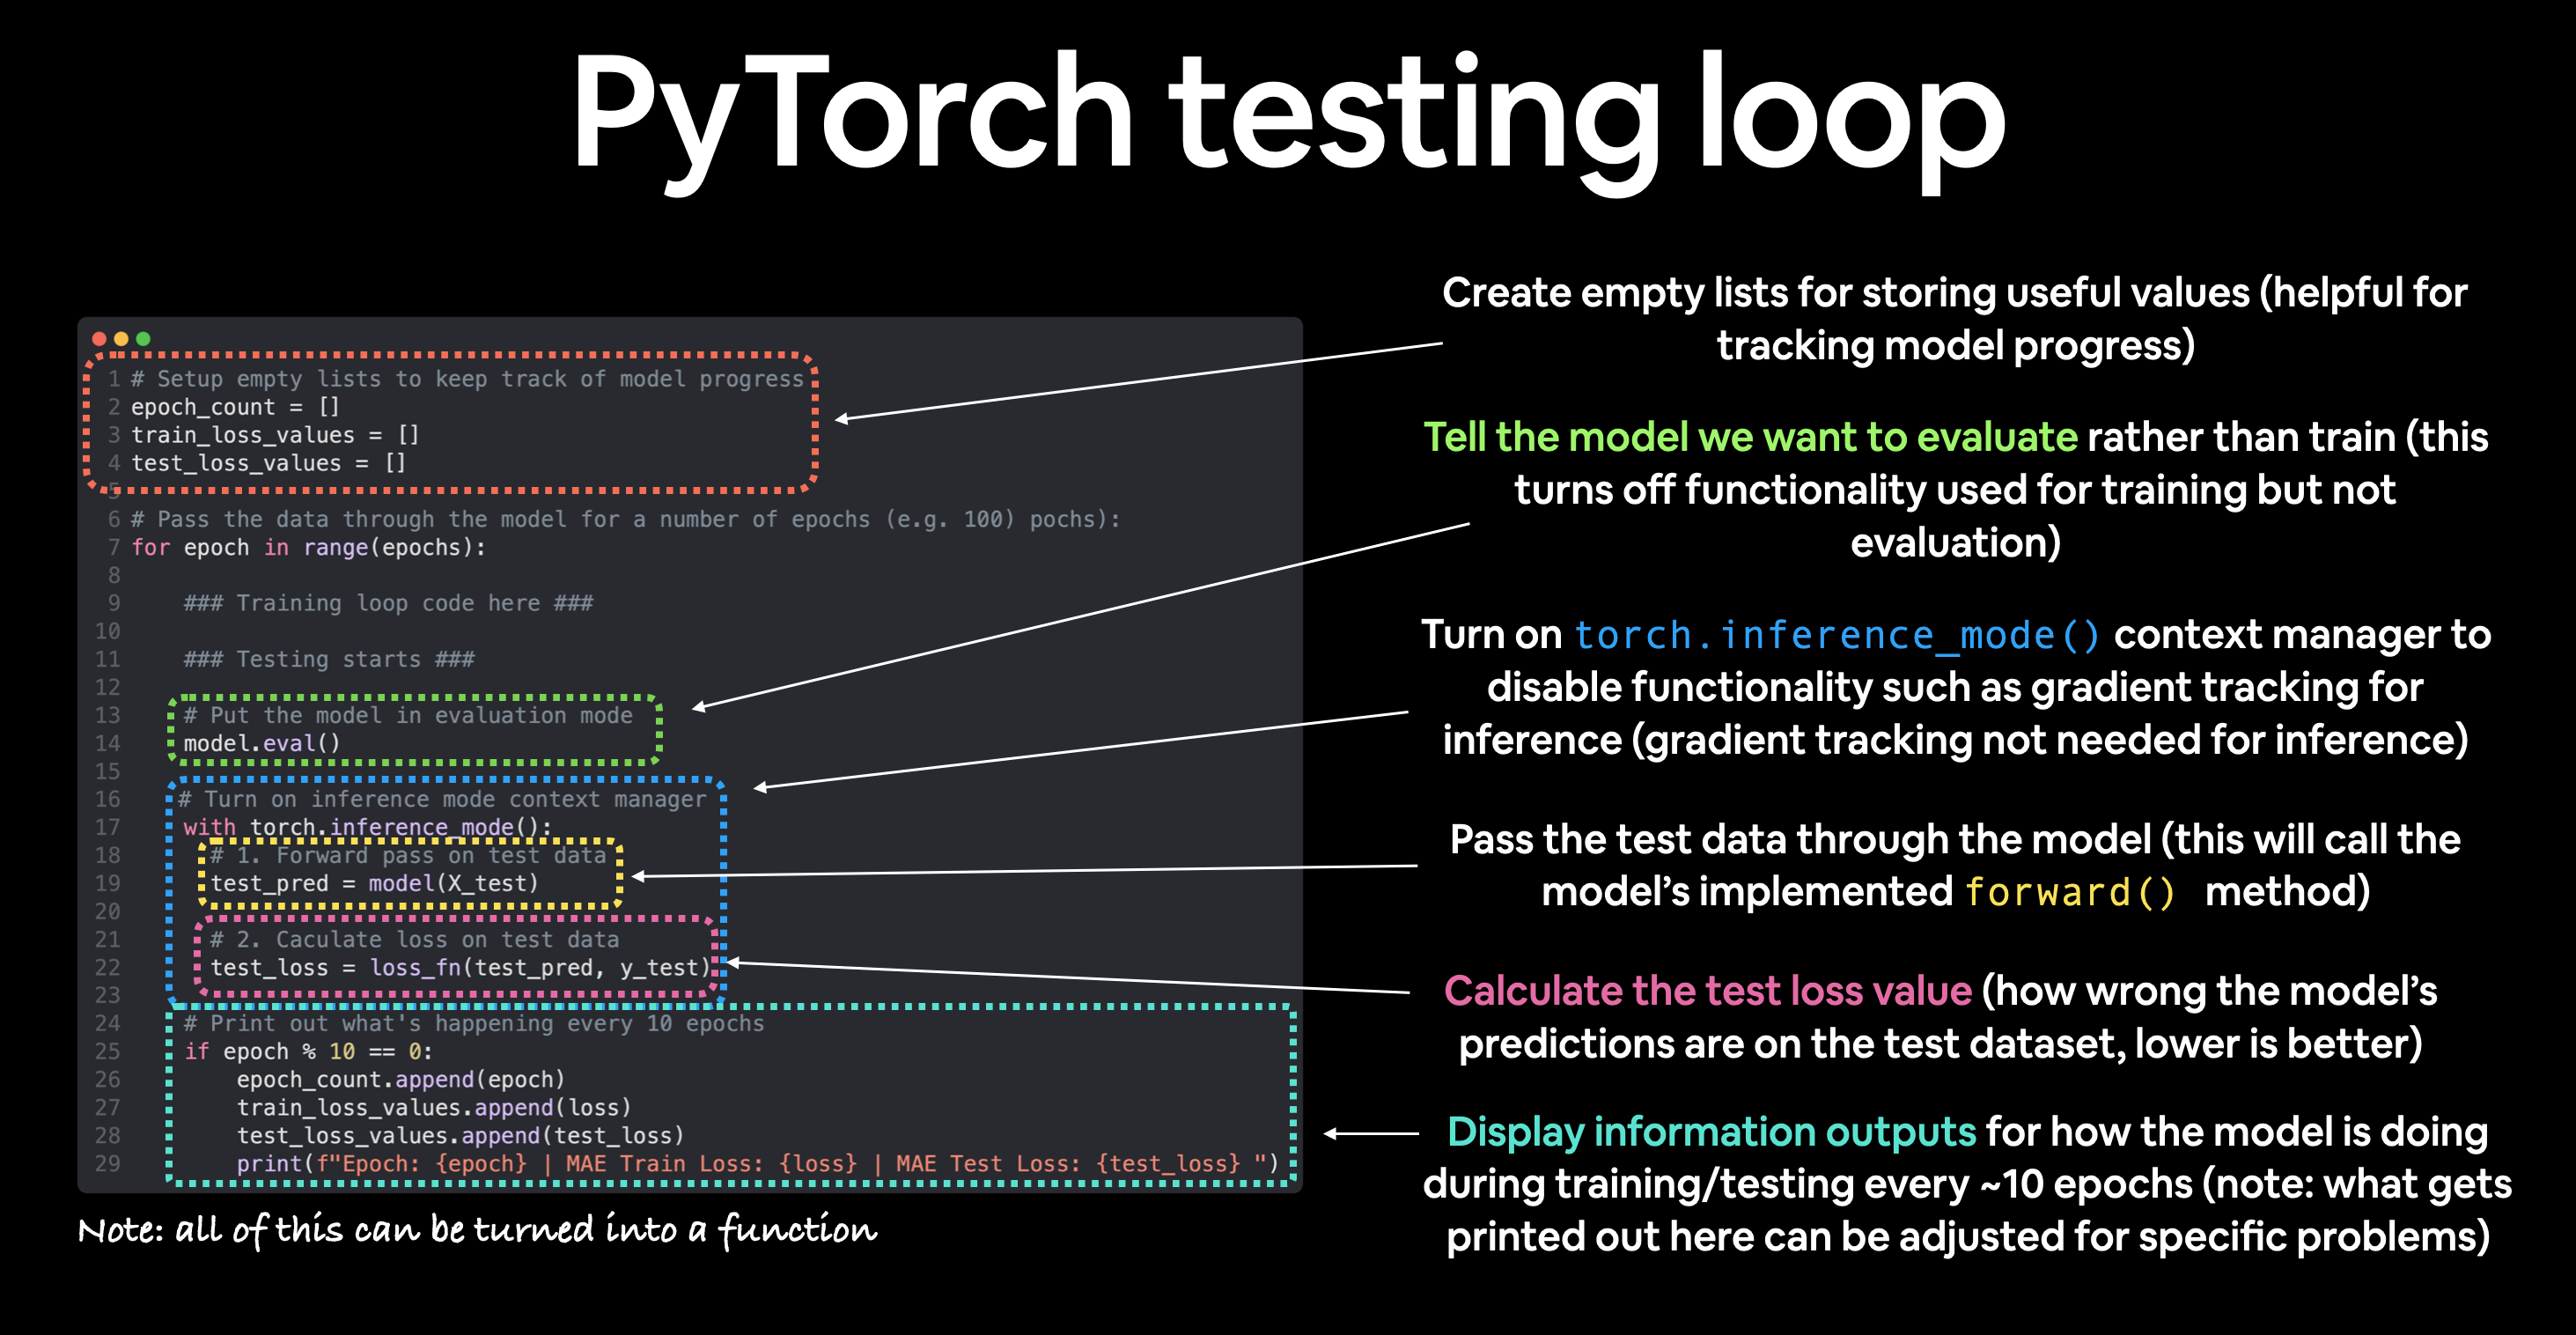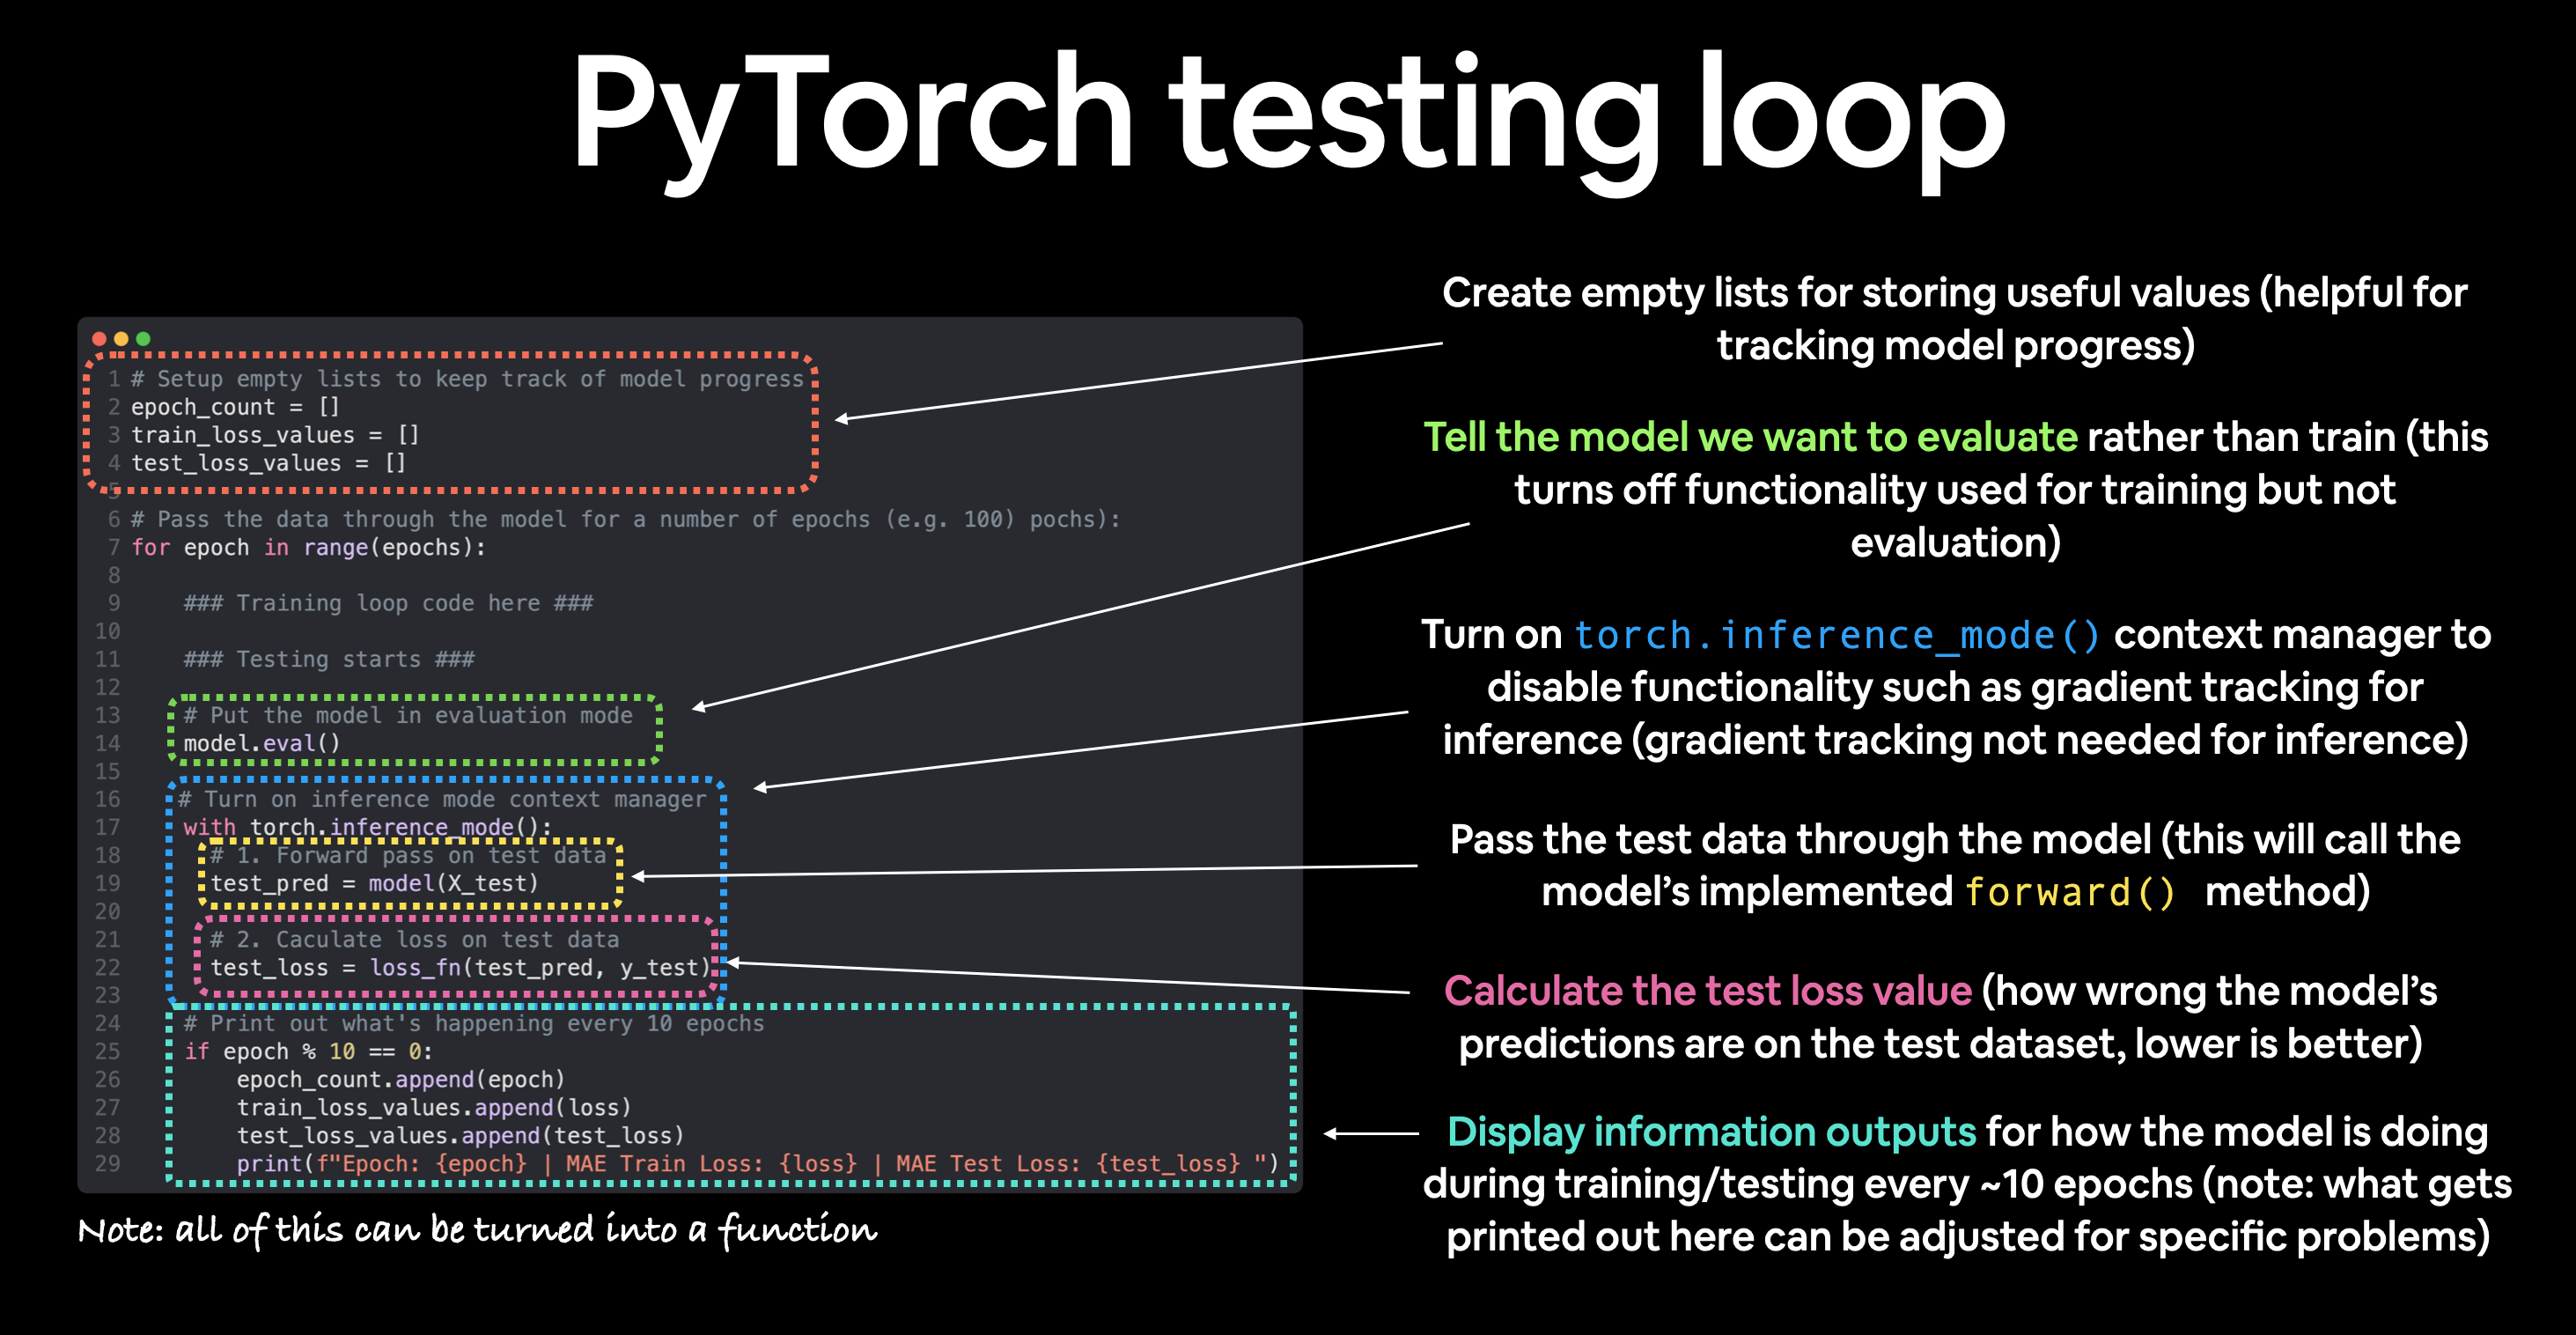

# Saving and loading a PyTorch mode

In [21]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [22]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

/bin/bash: /home/nhat/miniconda3/envs/test/lib/libtinfo.so.6: no version information available (required by /bin/bash)
-rw-rw-r-- 1 nhat nhat 1271 Jun  7 20:51 models/01_pytorch_workflow_model_0.pth


# Loading a saved PyTorch model's state_dict()

In [29]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel().to(device)

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [30]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test.to(device)) # perform a forward pass on the test data with the loaded model

In [31]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

#  Putting it all together

In [33]:

# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [34]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

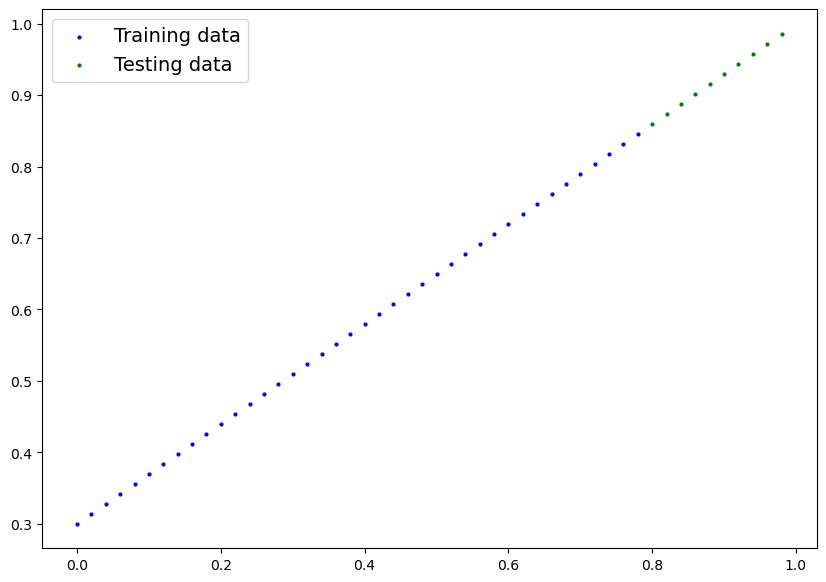

In [35]:

# Note: If you've reset your runtime, this function won't work, 
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

In [39]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear for creating the model parameters
        self.linear_layer = nn.Linear(in_features = 1, out_features = 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [40]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [41]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

In [42]:
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = .01)

In [53]:
torch.manual_seed(42)

epochs = 1000

# Put the data on the available device 

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Trainning loops 
for epoch in tqdm(range(epochs)):
    model_1.train() # Train mode
    
    #Forward pass
    y_pred = model_1(X_train)
    
    #Calculate loss
    loss = loss_fn(y_pred, y_train)
    # Zero grad opimizer
    optimizer.zero_grad()
    # Loss Backward
    loss.backward()
    # Optimizer step
    optimizer.step()
    ## Testing
    model_1.eval() # Evaluation mode
    with torch.inference_mode():
        test_pred = model_1(X_test)
        # Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
        

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1811.53it/s]


In [54]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [55]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

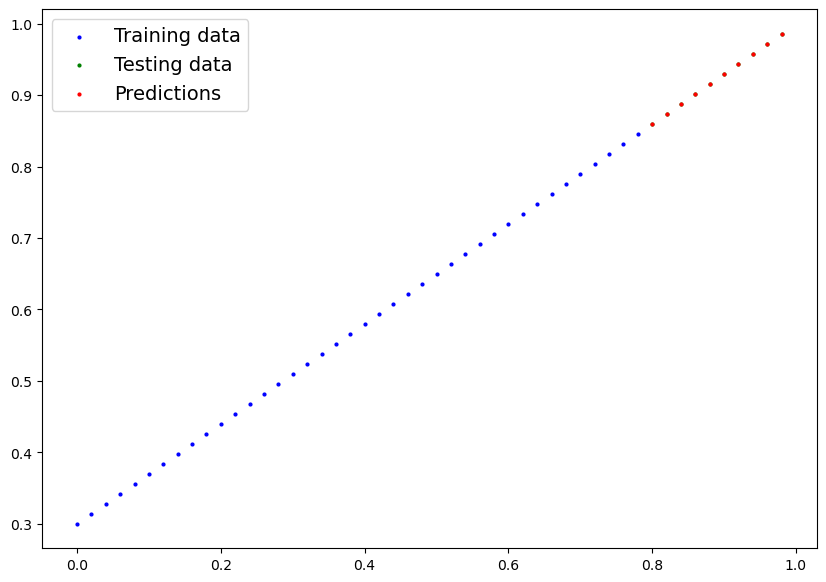

In [56]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

In [58]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [59]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [60]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')